In [1]:
import path_configs # noqa
import tensorflow as tf
import settings
from datetime import datetime
import pandas as pd
import os
import matplotlib.pyplot as plt
import scipy
import numpy as np
import librosa
settings.init()
import seaborn as sns
sns.set(font_scale=1.5, font="Arial", style="white")
from modules.ClassifierGenerators import (TrainClassifierGenerator,  # noqa
                                          ValidationClassifierGenerator)  # noqa

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

TRAIN_DATA_LEN: 3720334
VAL_DATA_LEN: 1593071


In [2]:
#assumes that array is not zero
def scaled(tensor):
    return (tensor-tf.math.reduce_min(tensor))/(tf.math.reduce_max(tensor)-tf.
                                                math.reduce_min(tensor))
def scaled_array(array):
    return (array - np.min(array))/(np.max(array) - np.min(array))

import scipy.spatial.distance as dist
def similarity(x1, x2):
    x1 = librosa.feature.mfcc(x1).flatten()
    x2 = scipy.signal.resample(librosa.feature.mfcc(x2).flatten(), len(x1))
    distance = dist.correlation(x1, x2)
    return 1/(1+distance)

from modules.DataPreprocessor import DataLoader
dl = DataLoader()
sample_rate = 48000
window_time = dl.window_time
frame_length = int(48000*window_time/1000)
frame_step = frame_length//4
def reverse_to_audio(db_spec):
    audio_rev_spec = librosa.db_to_power(db_spec, ref=1.0)
    print(
        'reversing'
    )
    return librosa.feature.inverse.mel_to_audio(audio_rev_spec, sr=48000, n_fft=frame_length, hop_length=frame_length//4)

In [3]:
train = pd.read_csv('data_info.csv')

In [4]:
audio = np.array(dl.load_audio_binary(30205))
cut_audio = dl.cut_voice(audio)
spec = dl.make_spectrogram(30205)

In [9]:
len(cut_audio)/48000

3.98

181.8181818181818

In [32]:
len(cut_audio)/dl.frame_step

723.6363636363636

In [ ]:
sample_rate/hop_length

3.9819999999999998

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


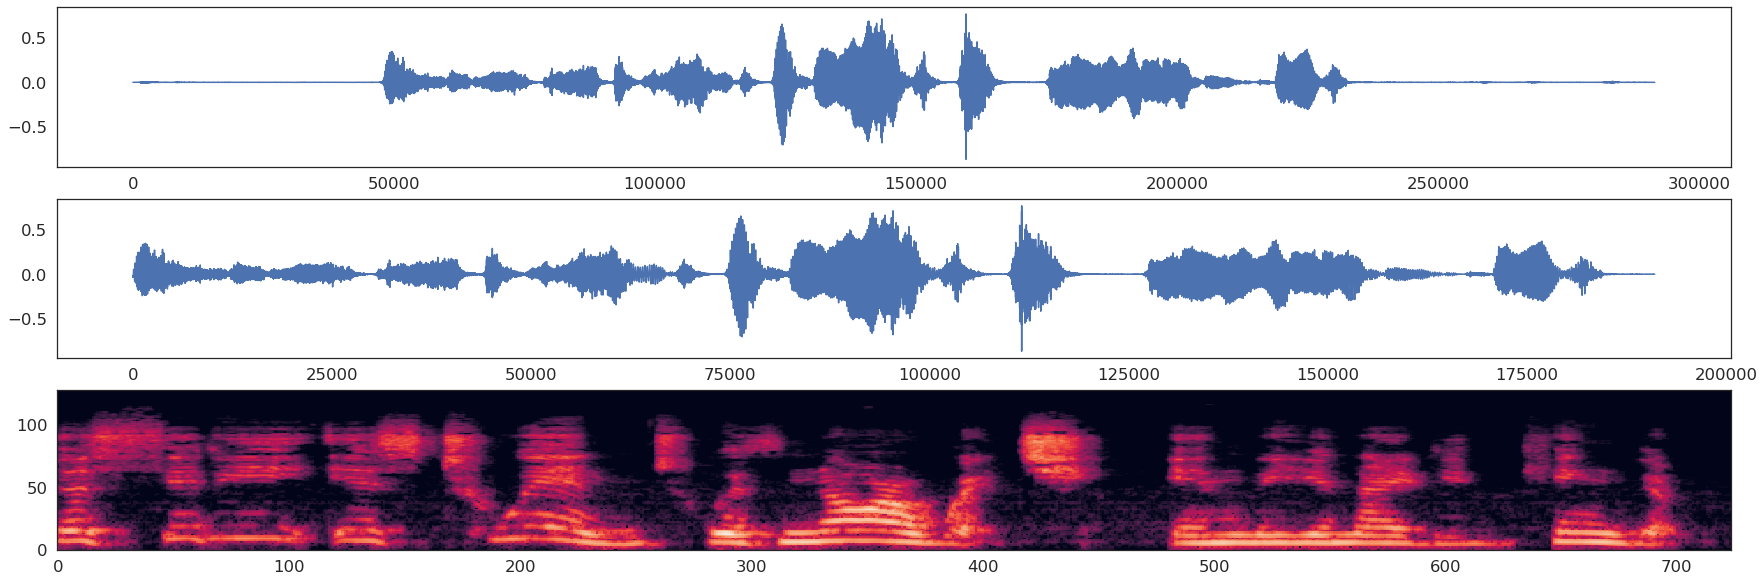

In [5]:
fig, ax = plt.subplots(figsize=(30, 10), nrows=3)
ax[0].plot(audio)
ax[1].plot(cut_audio)
ax[2].imshow(spec, aspect='auto', interpolation='nearest')
plt.gca().invert_yaxis()

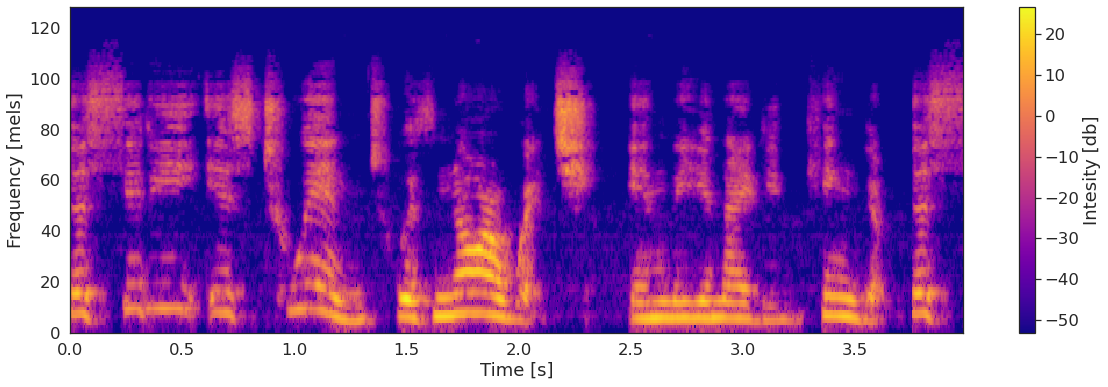

In [48]:
fig, ax = plt.subplots(figsize=(20, 6))
im = ax.imshow(dl.pad_spec(spec), aspect='auto', interpolation='nearest', cmap='plasma', extent=[0,spec.shape[1]*(dl.frame_step/48000),128,0])
cbar = plt.colorbar(im)
cbar.set_label('Intesity [db]')
ax.set(xlabel='Time [s]', ylabel='Frequency [mels]')
plt.gca().invert_yaxis()

In [7]:
dl.pad_spec(spec).shape

(128, 768)

In [8]:
int(np.ceil(spec.shape[1]/128)*128)

768

In [74]:
treshold = 0.1
treshold_plot = []
treshold_x = []

window = int(48000*0.02)
window_start = 0
window_end = window
L = len(audio)
while window_start < L:
    limit = min(window_end, L)
    if np.max(audio[ window_start:window_end ]) >= treshold:
        treshold_plot.append(True)
    else:
        treshold_plot.append(False)
    treshold_x.append(window_start)
    window_start += window
    window_end += window
treshold_plot = np.array(treshold_plot)
treshold_plot[np.where(treshold_plot==1)[0][0]:np.where(treshold_plot==1)[0][-1]]=True
tail = np.arange(np.where(treshold_plot==1)[0][-1], np.where(treshold_plot==1)[0][-1]+10, 1)
try:
    treshold_plot[tail]=1
except:
    print('bruh')



In [120]:
ax[2].get_position().get_points()

array([[0.06323958, 0.07631944],
       [0.8       , 0.32583333]])

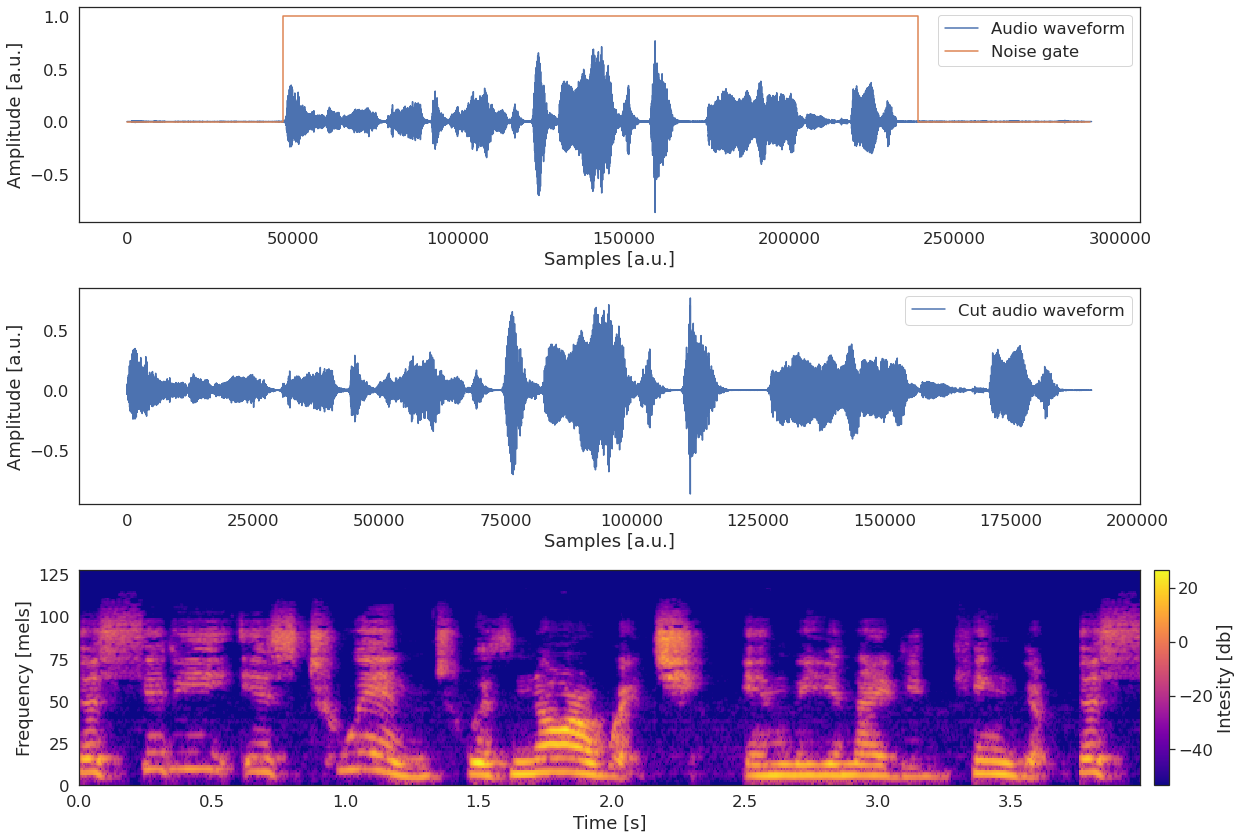

In [139]:
from mpl_toolkits.axes_grid1 import Divider, Size
fig, ax = plt.subplots(figsize=(20, 12), nrows=3)
ax[0].plot(audio, label='Audio waveform')
ax[0].plot(treshold_x, treshold_plot, drawstyle='steps', label='Noise gate')
ax[0].set(xlabel='Samples [a.u.]', ylabel='Amplitude [a.u.]')
ax[0].legend()

ax[1].plot(cut_audio, label='Cut audio waveform')
ax[1].set(xlabel='Samples [a.u.]', ylabel='Amplitude [a.u.]')
ax[1].legend()

im = ax[2].imshow(dl.pad_spec(spec), aspect='auto', interpolation='nearest', cmap='plasma', extent=[0,spec.shape[1]*(dl.frame_step/48000),128,0])

ax[2].set(xlabel='Time [s]', ylabel='Frequency [mels]')
plt.gca().invert_yaxis()
plt.tight_layout()

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([
    ax[2].get_position().get_points()[1, 0]+0.01,
    ax[2].get_position().get_points()[0, 1],
    0.01,
    ax[2].get_position().get_points()[1, 1]-ax[2].get_position().get_points()[0, 1]])
cbar = fig.colorbar(im, cax=cbar_ax, ax=ax[2])
cbar.set_label('Intesity [db]')
plt.savefig(os.path.join('figures', 'noise_cut_out.png'), bbox_inches = 'tight')
plt.show()



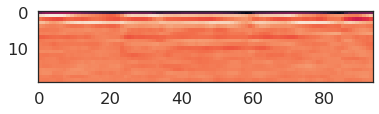

In [146]:
plt.imshow(librosa.feature.mfcc(cut_audio[:48000*], sr=48000))

In [10]:
from scipy.io.wavfile import write

scaled = np.int16(audio/np.max(np.abs(audio)) * 32767)
write('testOG.wav', 48000, scaled)

scaled2 = np.int16(cut_audio/np.max(np.abs(cut_audio)) * 32767)
write('test_recovered.wav', 48000, scaled2)